# Brain Tumor Prediction with Machine Learning

### 1. Motivation

A brain tumor is a mass or growth of abnormal cells in the brain. There are two main types: benign and malignant tumors. Some of them are primary, which means they start within the brain, others are secondary, which have spread from tumors outside the brain. The latter are known as brain metastasis tumors.

Doctors usually diagnose them by medical examination and magnetic resonance imaging(MRI). In our case, we will be predicting whether an MRI has a tumor in it.   
Firstly, we will be analyzing features from images like the Contrast, and then we will be using different models to analyse the images directly.

All data and information used is from the __[Brain Tumor](https://www.kaggle.com/jakeshbohaju/brain-tumor)__ repository on Kaggle.

### 2. Information about our Data

Our dataset is composed by 5 first-order features about images, and then 8 second-order features about textures. Our target is located in the column named *Class*, which is a binary one.  
*Class* will be 0 if the image does not have a tumor or 1 if it has one.
 
The other features are:  
- *Mean*   
- *Variance*    
- *Standard Deviation*   
- *Skewness*  
- *Kurtosis*   
- *Contrast*    
- *Energy*   
- *ASM*    
- *Entropy*    
- *Homogeneity*    
- *Correlation*    
- *Coarseness*

### 3. Libraries

The following libraries have been really useful to develop my code: 

- **numpy and pandas**: treat the data
- **matplotlib and seaborn**: visualitzation of the data
- **sklearn and pprint**: really useful to use diferent models and use hyperparameter tunning
- **time**: analyze timing aspects to see which model is faster
- **math**: maths functions
- **xgboost**: to use XGBoostClassifer
- **prettytable**: we can plot results in tables
- **joblib**: to export our models, variables and functions
- **pytorch and torchvision**: perform computer vision part


In [1]:
#Numpy and Pandas
import numpy as np
import pandas as pd

#Matplotlib and seaborn
from matplotlib import pyplot as plt
import seaborn as sns

#sklearn and pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,f1_score, confusion_matrix,plot_confusion_matrix,accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

#time
import time

#math
import math

#XGBoost
import xgboost as xgb

#PrettyTable
from prettytable import PrettyTable

#store variables and sessisons
import joblib
import dill

#pytorch and torchvision
import torch
from PIL import Image
from __future__ import print_function 
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import os
import copy
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.autograd import Variable
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

#warnings
import warnings
warnings.filterwarnings('ignore')

#show plots inline
%matplotlib inline



PyTorch Version:  1.9.1+cpu
Torchvision Version:  0.10.1+cpu


### 4. Some useful functions

We define MSE and regression functions in order to perform Linear Regression and Logistic Regressions.

We also define functions to plot precision-recall and ROC curves that will provide us more detailed information about our results.

In [2]:
def mean_squeared_error(y1, y2):
    # we check that y1 and y2 have same length
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squeared_error([1,2,3,4], [1,2,1,4])
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

def regression(x, y):
    # we create a regression object
    regr = LinearRegression()

    # we fit the object to predict
    regr.fit(x, y)

    # we rereturn the fitted model
    return regr
def Logisticregression(x, y):
    # we do the same as regression function but for Logistic model
    regr = LogisticRegression()


    regr.fit(x, y)

   
    return regr
#We calculate mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

In [3]:
#Function to plot precision-recall curve
def plot_precision_recall(probs, ax, title, y_v):
    precision = {}
    recall = {}
    average_precision = {}
    #ax.figure()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
        average_precision[i] = average_precision_score(y_v == i, probs[:, i])

        ax.plot(recall[i], precision[i],
        label='Precision-recall curve of class {0} (area = {1:0.2f})'
                               ''.format(i, average_precision[i]))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc="upper right")
    ax.set_title(title)
    return

    
# Function to plot ROC curve
def ROC(probs, ax, title, y_v):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    #plt.figure()
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    ax.legend()
    ax.set_title(title)
    return

### 5.Data Loading and Cleaning

In [4]:
# we will just use 3 decimals for each feature
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# function to read csv files
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# we load our dataset
dataset = load_dataset('Brain Tumor.csv')
data = dataset.values

df = pd.DataFrame(dataset)

x = data[:, :14]
y = data[:, 1]
print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Dimensionalitat de la BBDD: (3762, 15)
Dimensionalitat de les entrades X (3762, 14)
Dimensionalitat de l'atribut Y (3762,)


In [5]:
df

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535,619.588,24.892,0.109,4.276,18.901,98.614,0.293,0.086,0.531,4.473,0.982,0.000
1,Image2,0,8.750,805.958,28.389,0.267,3.718,14.465,63.859,0.475,0.226,0.651,3.220,0.989,0.000
2,Image3,1,7.341,1143.808,33.820,0.001,5.062,26.480,81.867,0.032,0.001,0.268,5.982,0.978,0.000
3,Image4,1,5.958,959.712,30.979,0.001,5.678,33.429,151.230,0.032,0.001,0.244,7.701,0.964,0.000
4,Image5,0,7.315,729.541,27.010,0.147,4.283,19.079,174.989,0.344,0.118,0.501,6.835,0.973,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3757,Image3758,0,21.235,1208.850,34.769,0.064,2.082,4.647,158.438,0.221,0.049,0.487,5.212,0.951,0.000
3758,Image3759,0,20.435,1227.151,35.031,0.067,2.145,4.882,161.159,0.226,0.051,0.503,5.083,0.953,0.000
3759,Image3760,0,18.012,1151.583,33.935,0.068,2.308,5.579,167.130,0.229,0.052,0.492,5.104,0.952,0.000
3760,Image3761,0,13.330,945.733,30.753,0.088,2.733,7.758,223.813,0.262,0.068,0.480,6.440,0.941,0.000


In [6]:
#we want to check the types of data of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3762 entries, 0 to 3761
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Image               3762 non-null   object 
 1   Class               3762 non-null   int64  
 2   Mean                3762 non-null   float64
 3   Variance            3762 non-null   float64
 4   Standard Deviation  3762 non-null   float64
 5   Entropy             3762 non-null   float64
 6   Skewness            3762 non-null   float64
 7   Kurtosis            3762 non-null   float64
 8   Contrast            3762 non-null   float64
 9   Energy              3762 non-null   float64
 10  ASM                 3762 non-null   float64
 11  Homogeneity         3762 non-null   float64
 12  Dissimilarity       3762 non-null   float64
 13  Correlation         3762 non-null   float64
 14  Coarseness          3762 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 441.0

In [7]:
#we check if there are any Nan values
print("Per comptar el nombre de valors no existents:")
print(df.isnull().sum())

Per comptar el nombre de valors no existents:
Image                 0
Class                 0
Mean                  0
Variance              0
Standard Deviation    0
Entropy               0
Skewness              0
Kurtosis              0
Contrast              0
Energy                0
ASM                   0
Homogeneity           0
Dissimilarity         0
Correlation           0
Coarseness            0
dtype: int64


In [8]:
#Since Coarseness i all 0 we drop it is not important
#Image is just the name of the Image so we can drop it to
#We put class column as float to keep the same type of data in the whole dataset
new_df= df.drop(['Coarseness'],axis=1)
new_df= new_df.drop(['Image'],axis=1)
new_df['Class'] = new_df['Class'].astype(float)
new_df.head()

,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation
0,0.000,6.535,619.588,24.892,0.109,4.276,18.901,98.614,0.293,0.086,0.531,4.473,0.982
1,0.000,8.750,805.958,28.389,0.267,3.718,14.465,63.859,0.475,0.226,0.651,3.220,0.989
2,1.000,7.341,1143.808,33.820,0.001,5.062,26.480,81.867,0.032,0.001,0.268,5.982,0.978
3,1.000,5.958,959.712,30.979,0.001,5.678,33.429,151.230,0.032,0.001,0.244,7.701,0.964
4,0.000,7.315,729.541,27.010,0.147,4.283,19.079,174.989,0.344,0.118,0.501,6.835,0.973


In [389]:
#we define a function to normalize our data, and normalize it before starting to manipulate it
def normalize_df(df):
    return((df-df.min())/(df.max()-df.min()))
dataset = normalize_df(new_df)

### 6.Data Analysis and Visualitzation
After cleaning our data we are ready to start analyzing it.  

First of all, we are going to plot some data in order to understand it better. We will start with how is our target distributed and then we will proceed to see the correlations between all our features. However, we will be focusing on the correlations with our target.

Nombre d'imatges totals per classe:
    Classe 0 (No Tumor): 2079
    Classe 1 (Tumor): 1683


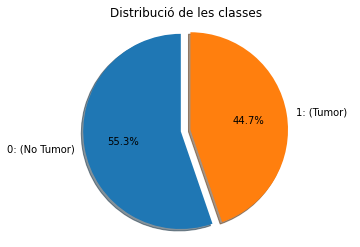

<Figure size 432x288 with 0 Axes>

In [10]:
#we are plotting our data distribution to see if data is balanced or not
print(f"""Nombre d'imatges totals per classe:
    Classe 0 (No Tumor): {dataset[dataset['Class']==0].count()[0]}
    Classe 1 (Tumor): {dataset[dataset['Class']==1].count()[0]}""")
labels = "0: (No Tumor)", "1: (Tumor)"
total = len(dataset)
no_tumor= dataset[dataset['Class']==0].count()[0]
tumor=dataset[dataset['Class']==1].count()[0]
sizes = [no_tumor/total, tumor/total]
explode = (0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Distribució de les classes")
plt.show()
plt.savefig("number_of_samples_breakdown")

Aproximately 55% of images do not have a tumor, so the rest will have a tumor. We can say that our data are balanced.

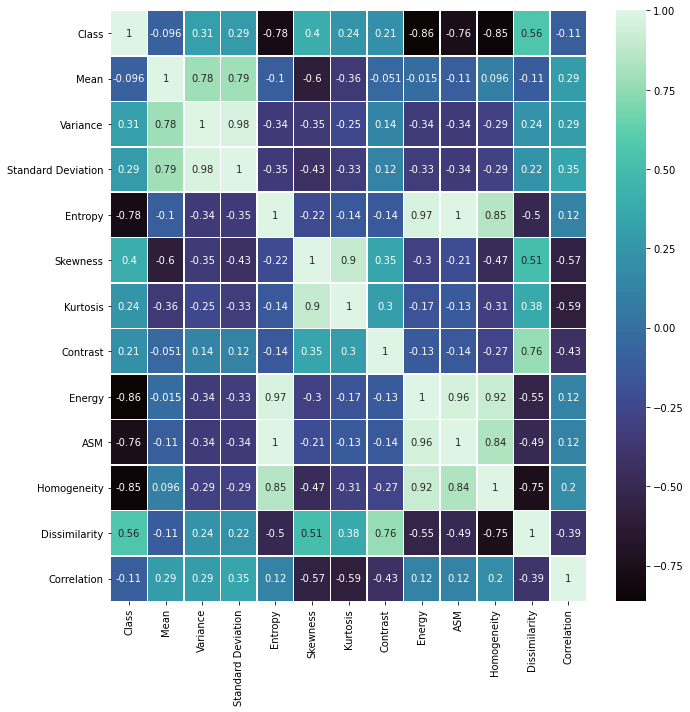

In [11]:
# We plot the heatmap in order to see the corralations between variables
correlacio = dataset.corr()

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(correlacio, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

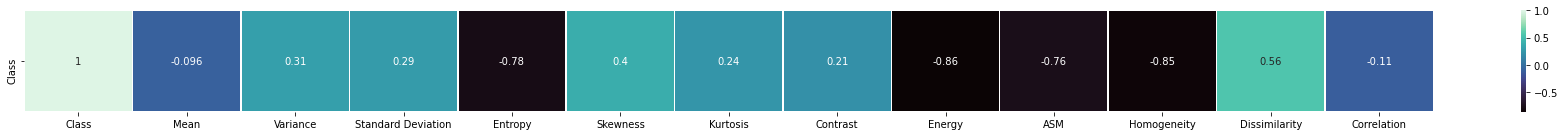

In [12]:
#we plot the row of the heatmap that is of our target
tumor = dataset.corr()['Class'].to_frame().T
fig, ax = plt.subplots(figsize=(25,2))         # Sample figsize in inches
sns.heatmap(tumor, annot=True, linewidths=.5, ax=ax, cmap="mako")

fig.tight_layout()

In [135]:
#we decide to keep those variables that have a bigger correaltion than the abs(0.25)
correlation_threshold = 0.25
attributes  = list(filter(lambda x: abs(float(dataset.corr()['Class'].to_frame().T[x])) > correlation_threshold, dataset.columns))
attributes.remove('Class')
corrTbl = PrettyTable()
corrTbl.field_names = ['Atribut']
for i in range(len(attributes)): 
    corrTbl.add_row([attributes[i]])
print(corrTbl)

+--------------------+
|      Atribut       |
+--------------------+
|      Variance      |
| Standard Deviation |
|      Entropy       |
|      Skewness      |
|       Energy       |
|        ASM         |
|    Homogeneity     |
|   Dissimilarity    |
+--------------------+


We obtained 8 different variables that have an interesting correlation with our target so we decided to take a look at their distribution classifying them by *Class*.

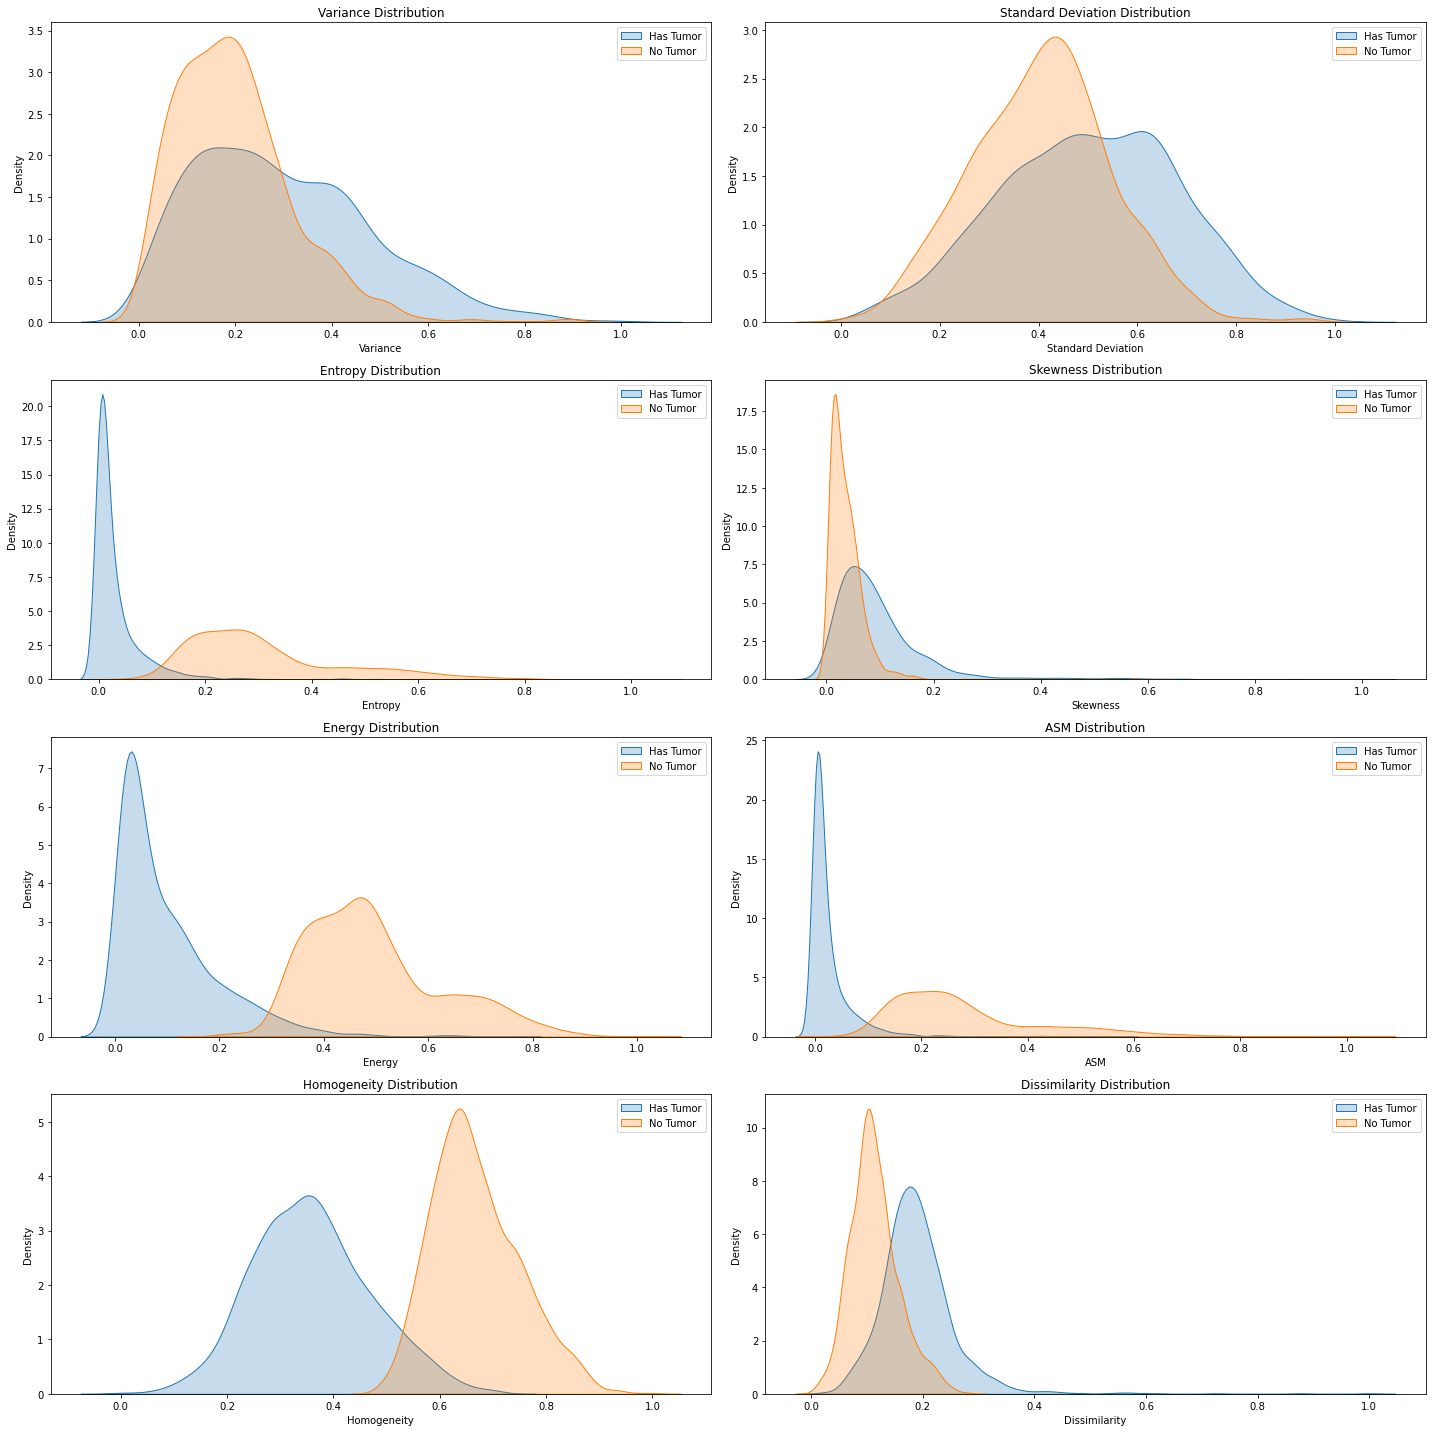

In [136]:
#we plot the distribution of those variables that are more correlated to our target
tumor = dataset[dataset['Class']==1]
no_tumor = dataset[dataset['Class']==0]
fig, axes = plt.subplots(4,2, figsize=(20,20))
ax = axes.ravel()

for i in range(len(attributes)): 
    ax[i].set_title(f'{attributes[i]} Distribution')
    if (i==0):
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[0,0])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[0,0])
    elif(i==1):
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[0,1])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[0,1])
    elif(i==2):
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[1,0])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[1,0])
    elif(i==3):
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[1,1])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[1,1])
    elif i==4:
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[2,0])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[2,0])
    elif i==5:        
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[2,1])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[2,1])
    elif i==6:    
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[3,0])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[3,0])
    elif i==7:
        sns.distplot(tumor[attributes[i]], hist=False, kde_kws={'shade':True},label="Has Tumor",ax=axes[3,1])
        sns.distplot(no_tumor[attributes[i]], hist=False, kde_kws={'shade': True}, label= "No Tumor",ax=axes[3,1])
    ax[i].legend(["Has Tumor", "No Tumor"], loc="best")
fig.tight_layout()
fig.savefig('distribution.png')
attributes.append('Class')

After watching these plots we can have an idea of which variables will be interesting to keep and which ones we will discard.

In [137]:
attributes_df = dataset.loc[:,attributes]
attributes_df.describe()

,Variance,Standard Deviation,Entropy,Skewness,Energy,ASM,Homogeneity,Dissimilarity,Class
count,3762.000,3762.000,3762.000,3762.000,3762.000,3762.000,3762.000,3762.000,3762.000
mean,0.243,0.449,0.185,0.063,0.319,0.167,0.530,0.148,0.447
std,0.161,0.168,0.179,0.073,0.229,0.168,0.181,0.068,0.497
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.124,0.331,0.015,0.021,0.079,0.012,0.368,0.101,0.000
50%,0.213,0.444,0.167,0.044,0.355,0.145,0.577,0.140,0.000
75%,0.331,0.562,0.286,0.079,0.485,0.256,0.666,0.186,1.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


We decided to use a violin plot in order to have a clear vision of what is happening with our data and select the best attributes.

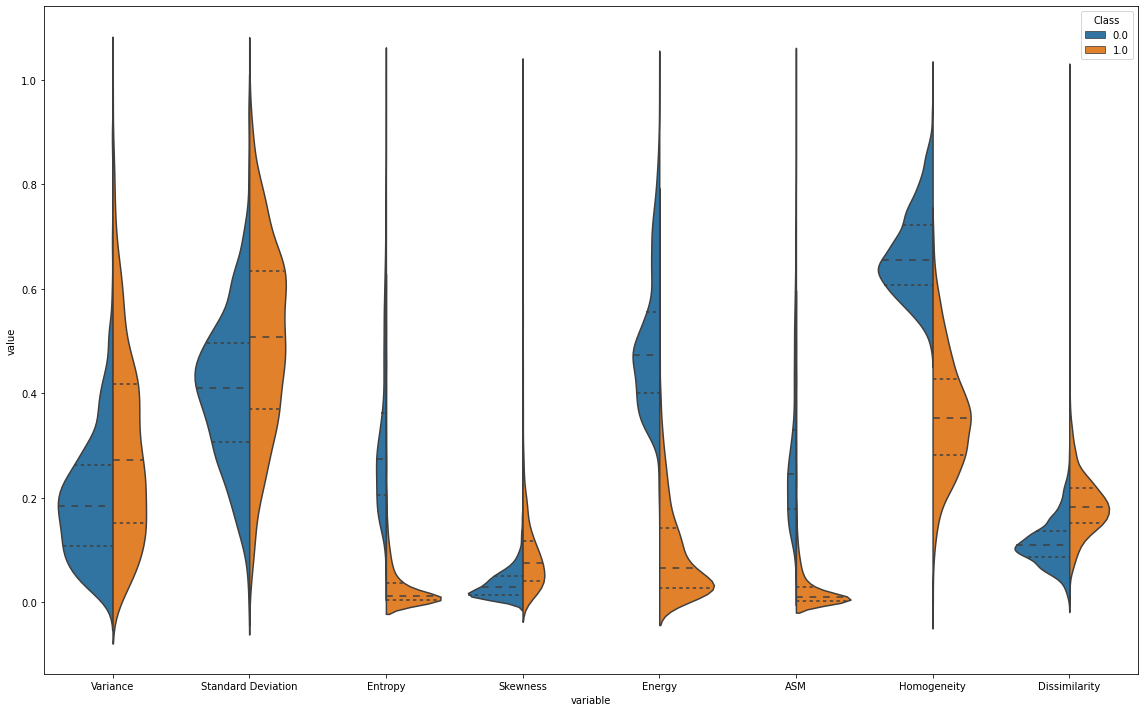

In [138]:
tumor_rel = dataset.Class
melted_data = pd.melt(attributes_df, id_vars = "Class")
plt.figure(figsize = (16,10))
sns.violinplot(x = "variable", y = "value", hue="Class", data = melted_data, split=True, inner="quartile")
plt.tight_layout()

### 7. Feature selection
Once we have seen the violin plot, we can clearly notice that there are some variables that are quite *nice*, they have a clear difference between having a tumor or not. So, we will just consider the following attributes to perform our analysis:

- *Entropy*
- *Energy*
- *ASM*
- *Homogeneity*
- *Dissmilarity*

We can see that usually the lower values indicate that there is a tumor, except for *Dissimilarity*, which works the opposite way.

### 8. Classification 
To classify our data we will be testing some different models. We will start with linear models and then we will proceed to use more complex models from sklearn.

In [139]:
variables = ["Entropy", "Energy", "ASM", "Homogeneity", "Dissimilarity"]
variablesIndex=[]
for i in range(len(variables)):
    variablesIndex.append(dataset.columns.get_loc(variables[i]))
predicted = []
for j,i in enumerate(variablesIndex):
    atribut2 = x[:,i].reshape(x.shape[0], 1) 
    regr = regression(atribut2, y) 
    predicted.append(regr.predict(atribut2))

# We calculate the mse and r2 for each variable, even though we are classifing a binary variable
# we print mse and r2 for each variable
for i in range(len(variables)):
    MSE = mse(y, predicted[i])
    r2 = r2_score(y, predicted[i])

    print("Mean squeared error attribute %s: %f" %(dataset.axes[1][variablesIndex[i]],MSE))
    print("R2 score: attribute %s: %f" %(dataset.axes[1][variablesIndex[i]],r2))
#we print the accuracies we get from using a linear regression
i = 0
for pred in predicted:
    correcte = 0
    incorrecte = 0
    for labels,p in zip(y,pred):
        if((labels == 0 and p<0.5) or (labels == 1 and p>=0.5)):
            correcte +=1
        else:
            incorrecte +=1
    print("Fent servir l'atribut",dataset.axes[1][variablesIndex[i]],"obtenim un accuracy de",correcte/len(pred))
    i +=1


Mean squeared error attribute Entropy: 0.227068
R2 score: attribute Entropy: 0.081549
Mean squeared error attribute Energy: 0.236051
R2 score: attribute Energy: 0.045217
Mean squeared error attribute ASM: 0.063351
R2 score: attribute ASM: 0.743756
Mean squeared error attribute Homogeneity: 0.105085
R2 score: attribute Homogeneity: 0.574950
Mean squeared error attribute Dissimilarity: 0.069643
R2 score: attribute Dissimilarity: 0.718305
Fent servir l'atribut Entropy obtenim un accuracy de 0.652046783625731
Fent servir l'atribut Energy obtenim un accuracy de 0.5930356193514088
Fent servir l'atribut ASM obtenim un accuracy de 0.9731525784157363
Fent servir l'atribut Homogeneity obtenim un accuracy de 0.9292929292929293
Fent servir l'atribut Dissimilarity obtenim un accuracy de 0.9481658692185008


We can see that performing a simple linear regression, we can obtain some good accuracies, however, we can improve them by applying other models to our data.

In [140]:
#we define our X and y to use the train_test_split function
attributes.remove('Class')
y = dataset.iloc[:,0]
X = dataset.loc[:,dataset.axes[1][variablesIndex]]

In [276]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)


We use some different models and calculate their accuracies in order to see which model is better. However, we are using default models because we will be improving or trying to do it later with hyperparameter tuning.

In [277]:
models = [LogisticRegression(random_state=123), DecisionTreeClassifier(random_state=123), RandomForestClassifier(random_state=123), 
          AdaBoostClassifier(random_state=123), xgb.XGBClassifier(random_state=123), MLPClassifier(random_state=123)]
model_names = ["Logistic", "Decision Tree", "Random Forest", "Ada Boost", "XGBoost", "Neural Network"]
false_negative = []
idx= 0
tbl = PrettyTable()
tbl.field_names = ['Model', 'Accuracy', 'Temps']
acc_without_hyperparameter = []
time_without_hyperparameter = []
for m in models: 
    start = time.time()
    m.fit(X_train, y_train)
    score = m.score(X_test, y_test)
    end = time.time()
    tbl.add_row([model_names[idx], score, end-start])
    acc_without_hyperparameter.append(score)
    time_without_hyperparameter.append(end-start)
    idx+=1

print(tbl)



[10:26:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+----------------+--------------------+----------------------+
|     Model      |      Accuracy      |        Temps         |
+----------------+--------------------+----------------------+
|    Logistic    | 0.9880478087649402 | 0.023934364318847656 |
| Decision Tree  | 0.9800796812749004 | 0.013962984085083008 |
| Random Forest  | 0.9907038512616202 | 0.40018749237060547  |
|   Ada Boost    | 0.9827357237715804 | 0.17750859260559082  |
|    XGBoost     | 0.9840637450199203 | 0.32567739486694336  |
| Neural Network | 0.9867197875166003 |  2.545048952102661   |
+----------------+--------------------+----------------------+


After training and testing our models we can see that the accuracies we obtained are pretty good ones, and that could be because our data are pretty well separeted which allows our models to classify such data well.

In [278]:
#we define some list to create a table later to compare between models
acc_hyperparameter = []
improve = []

In [226]:
time_hyperparameter = []

#### LOGISTIC REGRESSION

In [227]:
#LOGISTIC REGRESSION
penalty = ['l1', 'l2','elasticnet','none']

dual = [True, False]

tol = [x for x in np.linspace(1e-4, 0.1, num = 50)]

C = [x for x in np.linspace(0.001,10, num = 50)]

solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

lr_grid = {'penalty': penalty,
               'dual': dual,
               'tol':tol,
               'C': C,
               'solver': solver}

In [228]:
lr = LogisticRegression(random_state=123)
lr_random = RandomizedSearchCV(estimator = lr, param_distributions = lr_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
lr_random.fit(X_train, y_train)
end = time.time()
time_hyperparameter.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


In [229]:
lr_random.best_params_

{'tol': 0.1,
 'solver': 'newton-cg',
 'penalty': 'none',
 'dual': False,
 'C': 9.387816326530613}

In [279]:
base_model = LogisticRegression(random_state = 123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9880478087649402

In [280]:
best_random = lr_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
acc_hyperparameter.append(random_accuracy)
random_accuracy


0.9907038512616202

In [281]:
improve.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.27%.


In [282]:
print("                       REGRESSIÓ LOGÍSTICA                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                       REGRESSIÓ LOGÍSTICA                      
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9907038512616202 | 0.9880952380952381 | 0.9895678092399405 |
+--------------------+--------------------+--------------------+


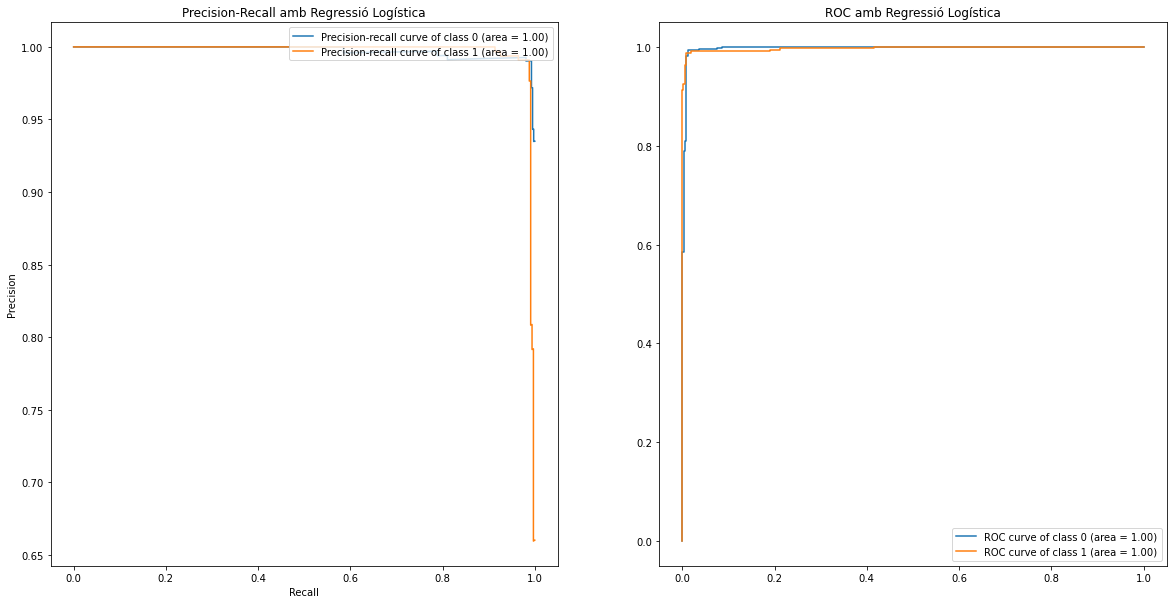

In [283]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb Regressió Logística', y_v=y_test)
ROC(probs, ax[1], 'ROC amb Regressió Logística', y_v=y_test)

#### DECISION TREE

In [235]:
#DECISION TREE

criterion = ['gini', 'entropy']

max_features = ['auto', 'sqrt','log2']

max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

dt_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

In [236]:
dt = DecisionTreeClassifier(random_state=123)
dt_random = RandomizedSearchCV(estimator = dt, param_distributions = dt_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
dt_random.fit(X_train, y_train)
end = time.time()
time_hyperparameter.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


In [237]:
dt_random.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 35,
 'criterion': 'gini'}

In [284]:
base_model = DecisionTreeClassifier(random_state = 123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9800796812749004

In [285]:
best_random = dt_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
acc_hyperparameter.append(random_accuracy)
random_accuracy

0.9827357237715804

In [286]:
improve.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.27%.


In [287]:
print("                          DECISION TREE                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                          DECISION TREE                      
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9827357237715804 | 0.9732142857142857 | 0.9805097451274363 |
+--------------------+--------------------+--------------------+


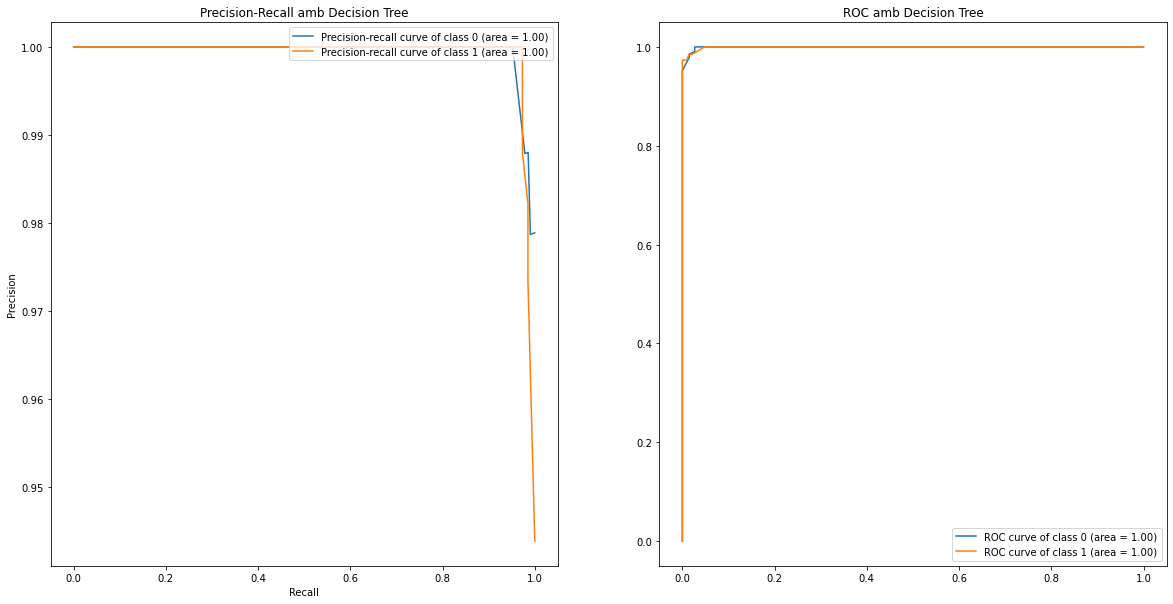

In [288]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb Decision Tree', y_v=y_test)
ROC(probs, ax[1], 'ROC amb Decision Tree', y_v=y_test)

#### RANDOM FOREST

In [243]:
#RANDOM FOREST

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 4000, num = 100)]

max_features = ['auto', 'sqrt','log2']

max_depth = [int(x) for x in np.linspace(10, 110, num = 110)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [244]:
rf = RandomForestClassifier(random_state=123)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
rf_random.fit(X_train, y_train)
end = time.time()
time_hyperparameter.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.0min finished


In [376]:
rf_random.best_params_

{'n_estimators': 612,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 61,
 'bootstrap': True}

In [289]:
base_model = RandomForestClassifier(random_state = 123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9907038512616202

In [290]:
best_random = rf_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
acc_hyperparameter.append(random_accuracy)
random_accuracy

0.9933598937583001

In [291]:
improve.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.27%.


In [292]:
print("                          RANDOM FOREST                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                          RANDOM FOREST                      
+--------------------+--------------------+-------------------+
|      Accuracy      |       Recall       |      F1Score      |
+--------------------+--------------------+-------------------+
| 0.9933598937583001 | 0.9880952380952381 | 0.992526158445441 |
+--------------------+--------------------+-------------------+


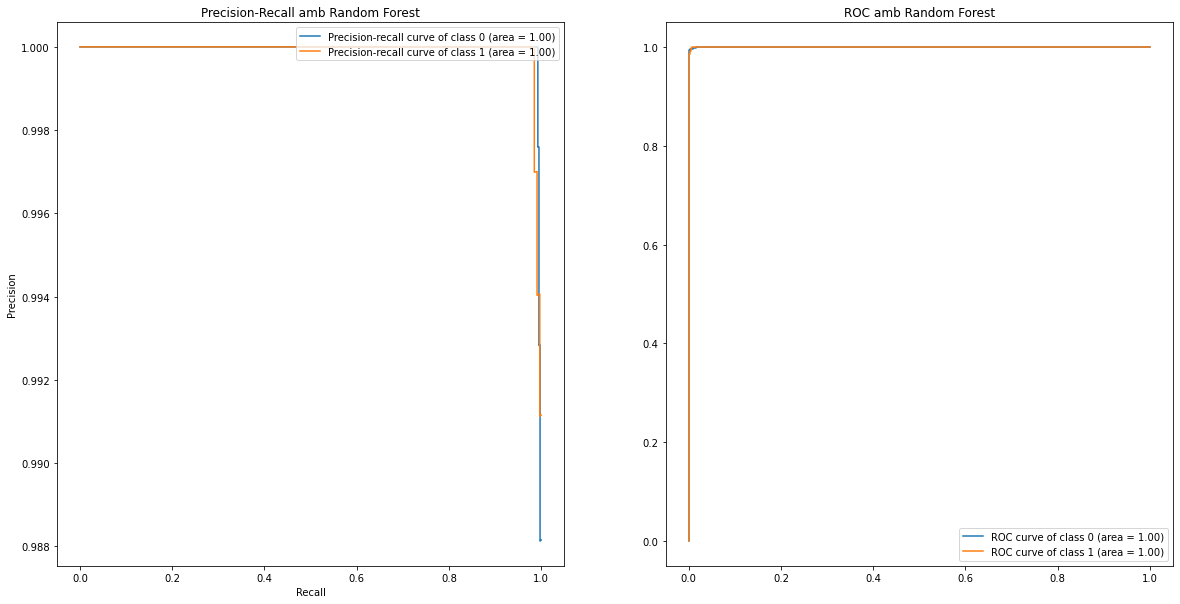

In [293]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb Random Forest', y_v=y_test)
ROC(probs, ax[1], 'ROC amb Random Forest', y_v=y_test)

#### ADA BOOST CLASSIFIER

In [251]:
#ADA BOOST CLASSIFIER

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 4000, num = 100)]

algorithm = ['SAMME', 'SAMME.R']

learning_rate = [x for x in np.linspace(0.001, 1, num = 100)]

ada_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'algorithm': algorithm
              }


In [252]:
ada = AdaBoostClassifier(random_state=123)
ada_random = RandomizedSearchCV(estimator = ada, param_distributions = ada_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
ada_random.fit(X_train, y_train)
end = time.time()
time_hyperparameter.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.1min finished


In [253]:
ada_random.best_params_

{'n_estimators': 1566,
 'learning_rate': 0.2330909090909091,
 'algorithm': 'SAMME'}

In [294]:
base_model = AdaBoostClassifier(random_state = 123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9827357237715804

In [295]:
best_random = ada_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
acc_hyperparameter.append(random_accuracy)
random_accuracy

0.9907038512616202

In [296]:
improve.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.81%.


In [297]:
print("                      ADA BOOST CLASSIFIER                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                      ADA BOOST CLASSIFIER                      
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9907038512616202 | 0.9880952380952381 | 0.9895678092399405 |
+--------------------+--------------------+--------------------+


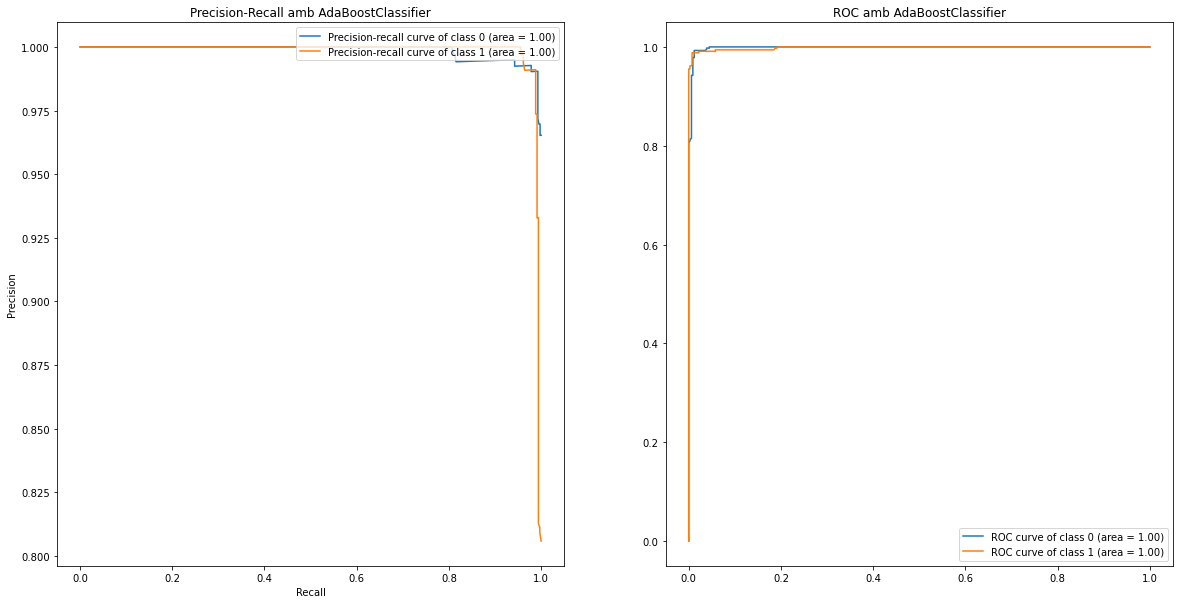

In [298]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb AdaBoostClassifier', y_v=y_test)
ROC(probs, ax[1], 'ROC amb AdaBoostClassifier', y_v=y_test)

#### XGBOOST CLASSIFIER

In [259]:
#XGBOOST
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 4000, num = 100)]

max_depth = [int(x) for x in range (3,18,1)]

gamma = [int(x) for x in range(1,9,1)]

reg_alpha = [int(x) for x in range(40,180,5)]

reg_lambda = [int(x) for x in range(0,1)]

colsample = [i/10.0 for i in range(6,10)]

xgb_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'gamma':gamma,
                'reg_alpha':reg_alpha,
                'reg_lambda':reg_lambda,
                'colsample_bytree':colsample
              }

In [260]:
xb = xgb.XGBClassifier(random_state=123)
xb_random = RandomizedSearchCV(estimator = xb, param_distributions = xgb_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
xb_random.fit(X_train, y_train)
end = time.time()
time_hyperparameter.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.4min finished


[10:16:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [365]:
xb_random.best_params_

{'reg_lambda': 0,
 'reg_alpha': 70,
 'n_estimators': 3093,
 'max_depth': 16,
 'gamma': 4,
 'colsample_bytree': 0.8}

In [299]:
base_model = xgb.XGBClassifier(random_state = 123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

[10:27:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9840637450199203

In [300]:
best_random = xb_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
acc_hyperparameter.append(random_accuracy)
random_accuracy

0.9907038512616202

In [301]:
improve.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.67%.


In [302]:
print("                       XGBOOST CLASSIFIER                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                       XGBOOST CLASSIFIER                      
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9907038512616202 | 0.9880952380952381 | 0.9895678092399405 |
+--------------------+--------------------+--------------------+


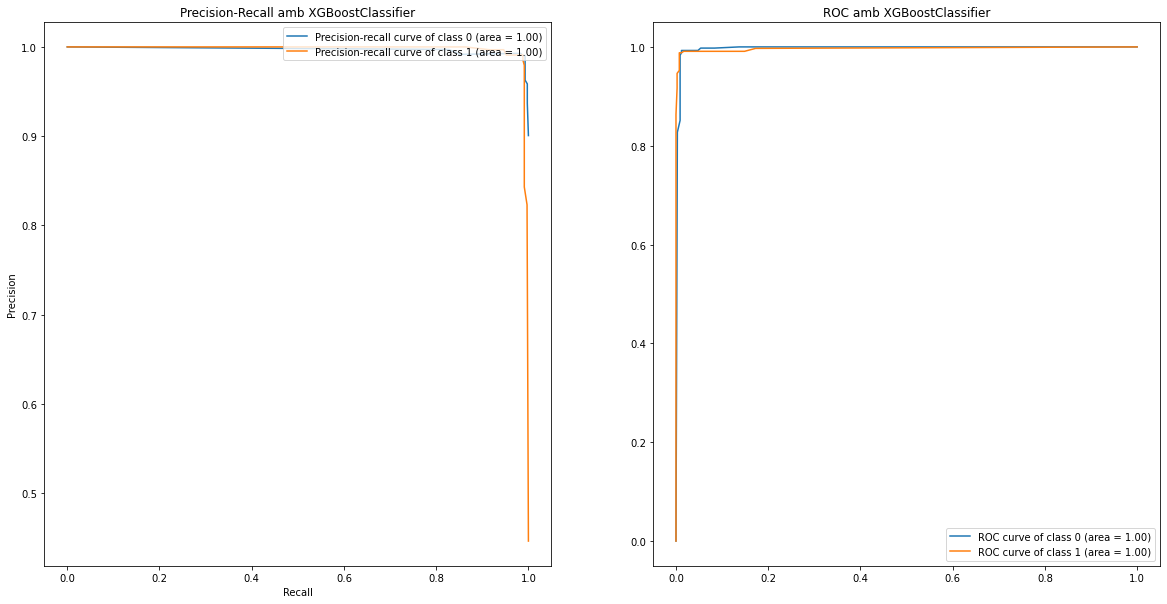

In [303]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb XGBoostClassifier', y_v=y_test)
ROC(probs, ax[1], 'ROC amb XGBoostClassifier', y_v=y_test)

#### MULTI LAYER PERCEPTRON (NEURONAL NETWORK)

In [266]:
#MULTI LAYER PERCEPTRON
mlp_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [267]:
mlp = MLPClassifier(random_state=123)
mlp_random = RandomizedSearchCV(estimator = mlp, param_distributions = mlp_grid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
mlp_random.fit(X_train, y_train)
end =  time.time()
time_hyperparameter.append(end-start)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.7min finished


In [366]:
mlp_random.best_params_

{'solver': 'sgd',
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 50, 50),
 'alpha': 0.0001,
 'activation': 'tanh'}

In [304]:
base_model = MLPClassifier(random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9867197875166003

In [305]:
best_random = mlp_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
acc_hyperparameter.append(random_accuracy)
random_accuracy

0.9893758300132802

In [306]:
improve.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.27%.


In [307]:
print("                     MULTI LAYER PERCEPRTON                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                     MULTI LAYER PERCEPRTON                      
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9893758300132802 | 0.9851190476190477 | 0.9880597014925373 |
+--------------------+--------------------+--------------------+


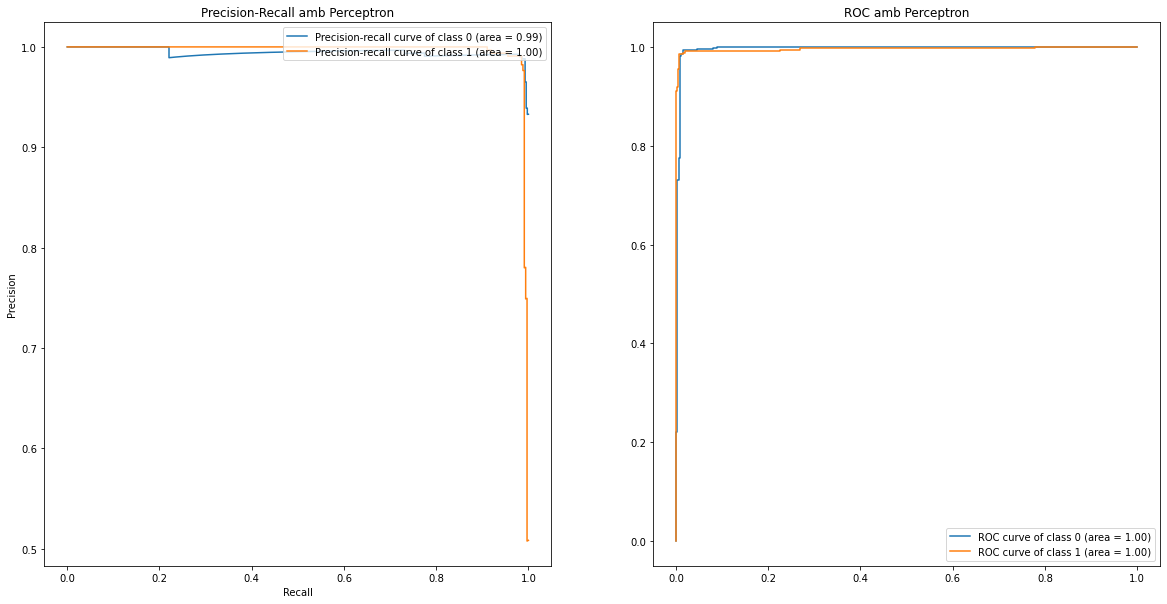

In [308]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb Perceptron', y_v=y_test)
ROC(probs, ax[1], 'ROC amb Perceptron', y_v=y_test)

In [406]:
compare_tbl = PrettyTable()
compare_tbl.field_names = ['Model', 'Accuracy w/o HT', 'Accuracy w/ HT', 'Time spent on HT (s)','Improve']
idx = 0
for m in model_names: 
    compare_tbl.add_row([m, acc_without_hyperparameter[idx], acc_hyperparameter[idx],time_hyperparameter[idx],improve[idx]])
    idx+=1
print(compare_tbl)

+----------------+--------------------+--------------------+----------------------+---------------------+
|     Model      |  Accuracy w/o HT   |   Accuracy w/ HT   | Time spent on HT (s) |       Improve       |
+----------------+--------------------+--------------------+----------------------+---------------------+
|    Logistic    | 0.9880478087649402 | 0.9907038512616202 |  1.015202283859253   | 0.26881720430107503 |
| Decision Tree  | 0.9800796812749004 | 0.9827357237715804 |  1.5522537231445312  |   0.2710027100271   |
| Random Forest  | 0.9907038512616202 | 0.9933598937583001 |   1080.22319149971   | 0.26809651474530805 |
|   Ada Boost    | 0.9827357237715804 | 0.9907038512616202 |  1031.5584931373596  |  0.8108108108108101 |
|    XGBoost     | 0.9840637450199203 | 0.9907038512616202 |  750.2783348560333   |  0.6747638326585689 |
| Neural Network | 0.9867197875166003 | 0.9893758300132802 |  232.3188178539276   |  0.2691790040376848 |
+----------------+--------------------+-------

In [401]:
models = [lr_random.best_estimator_, dt_random.best_estimator_, rf_random.best_estimator_, 
          ada_random.best_estimator_, xb_random.best_estimator_, mlp_random.best_estimator_]
train_tbl = PrettyTable()
train_tbl.field_names = ['Model', 'Accuracy w/o HT', 'Accuracy w/ HT', 'Time w/o HT(s)', 'Time w/ HT (s)']
idx = 0
for m in models: 
    start = time.time()
    m.fit(X_train, y_train)
    end = time.time()
    train_tbl.add_row([model_names[idx], acc_without_hyperparameter[idx], acc_hyperparameter[idx], time_without_hyperparameter[idx],end-start])
    idx+=1
print(train_tbl)

[21:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
+----------------+--------------------+--------------------+----------------------+----------------------+
|     Model      |  Accuracy w/o HT   |   Accuracy w/ HT   |    Time w/o HT(s)    |    Time w/ HT (s)    |
+----------------+--------------------+--------------------+----------------------+----------------------+
|    Logistic    | 0.9880478087649402 | 0.9907038512616202 | 0.023934364318847656 | 0.027925729751586914 |
| Decision Tree  | 0.9800796812749004 | 0.9827357237715804 | 0.013962984085083008 | 0.005983829498291016 |
| Random Forest  | 0.9907038512616202 | 0.9933598937583001 | 0.40018749237060547  |  1.997924566268921   |
|   Ada Boost    | 0.9827357237715804 | 0.990703

We can see that most of them have an improvement after tuning their hyperparameters, however, the time we spent training is really different. Despite spending a long time training our model, we intend to classify something as important as having a tumor or not, so we need the best model possible and that model will be the one with best accuracy.

Now, we shall observe the confusion matrices because despite their high accuracies, they could show some differences between how they classify. We think that the best model will be the one that gives you less False Negative cases as that would be the best scenario.

In [316]:
models = [lr_random.best_estimator_, dt_random.best_estimator_, rf_random.best_estimator_, ada_random.best_estimator_, xb_random.best_estimator_, mlp_random.best_estimator_]
false_negative = []
for m in models:
    pred = m.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    false_negative.append(fn)

#print(f"El model més bo és el {model_names[false_negative.index(min(false_negative))]} amb {min(false_negative)} falsos negatius")

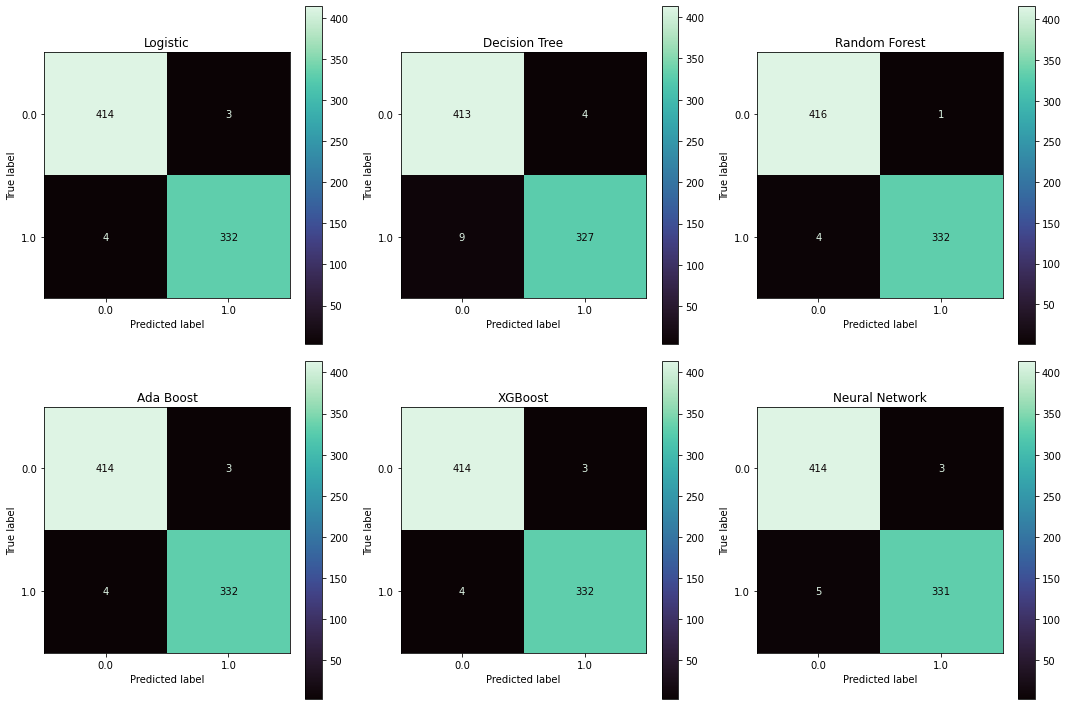

In [311]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
idx=0
for cls, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='mako',
                         )
    ax.title.set_text(model_names[idx])
    idx+=1
    #ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

Now we decided to check different **SVM** models to see if there is any model better than the ones we just tested.

In [404]:
#Many models of SVM

svm_models= [svm.SVC(kernel='linear', random_state=123),
              svm.LinearSVC( max_iter=1000000,random_state=123),
              svm.SVC(kernel='rbf',random_state=123),
              svm.SVC(kernel='poly',random_state=123),
              svm.SVC(kernel='sigmoid', random_state=123)]
svm_kernels = ["Linear","SVC Linear", "RBF", "Polyniomial", "Sigmoid"]
idx= 0
svmtbl = PrettyTable()
svmtbl.field_names = ['Model', 'Accuracy', 'Temps']
svm_fn = []
svm_nohyper = []
svm_time_nohyper = []
for svm in svm_models:
    start =  time.time()
    svm.fit(X_train, y_train)
    score = svm.score(X_train,y_train)
    end = time.time()
    svmtbl.add_row([svm_kernels[idx], score, end-start])
    svm_nohyper.append(score)
    svm_time_nohyper.append(end-start)
    pred = svm.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    svm_fn.append(fn)
    #print(f"Utilitzant el kernel {svm_kernels[idx]} obtenim una accuracy de: {svm.score(X_train,y_train)}")
    idx+=1
print(svmtbl)


+-------------+---------------------+----------------------+
|    Model    |       Accuracy      |        Temps         |
+-------------+---------------------+----------------------+
|    Linear   |  0.9727484214024593 | 0.03191637992858887  |
|  SVC Linear |  0.9717514124293786 | 0.006978273391723633 |
|     RBF     |  0.9744101030242606 | 0.03988242149353027  |
| Polyniomial |  0.9777334662678631 | 0.032918453216552734 |
|   Sigmoid   | 0.21468926553672316 |  0.4429788589477539  |
+-------------+---------------------+----------------------+


After having a first impression we can get an idea that results will be quite similar with the ones we got before. We might point out that *Sigmoid* kernel seems to be the worst one, it also works worse than just predicting that all our classes are from the same *Class*. But, let's apply hyperparameters to see if they improve or not.

In [318]:
#HYPERPARAMETER TUNNING SVM
#we create some lists to compare in the future and restart svm library to reestart svm objects
from sklearn import svm
svm_hyper = []
svm_timehyper = []
improve_svm = []

#### SVM KERNEL LINEAR

In [319]:
#svm kernel linear
C = [x for x in np.linspace(start = 0.001, stop = 10, num = 1000)]


linear = {'C': C,
              }


In [320]:
svm_linear = svm.SVC(kernel='linear',random_state=123, probability=True)
sl_random = RandomizedSearchCV(estimator = svm_linear, param_distributions = linear, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
sl_random.fit(X_train, y_train)
end = time.time()
svm_timehyper.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.3s finished


In [367]:
sl_random.best_params_

{'C': 2.6633963963963967}

In [321]:
base_model = svm.SVC(kernel='linear',random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9880478087649402

In [322]:
best_random = sl_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_hyper.append(random_accuracy)
random_accuracy

0.9893758300132802

In [323]:
improve_svm.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.13%.


In [324]:
print("                       SVM KERNEL LINEAR                      ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                       SVM KERNEL LINEAR                      
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9893758300132802 | 0.9851190476190477 | 0.9880597014925373 |
+--------------------+--------------------+--------------------+


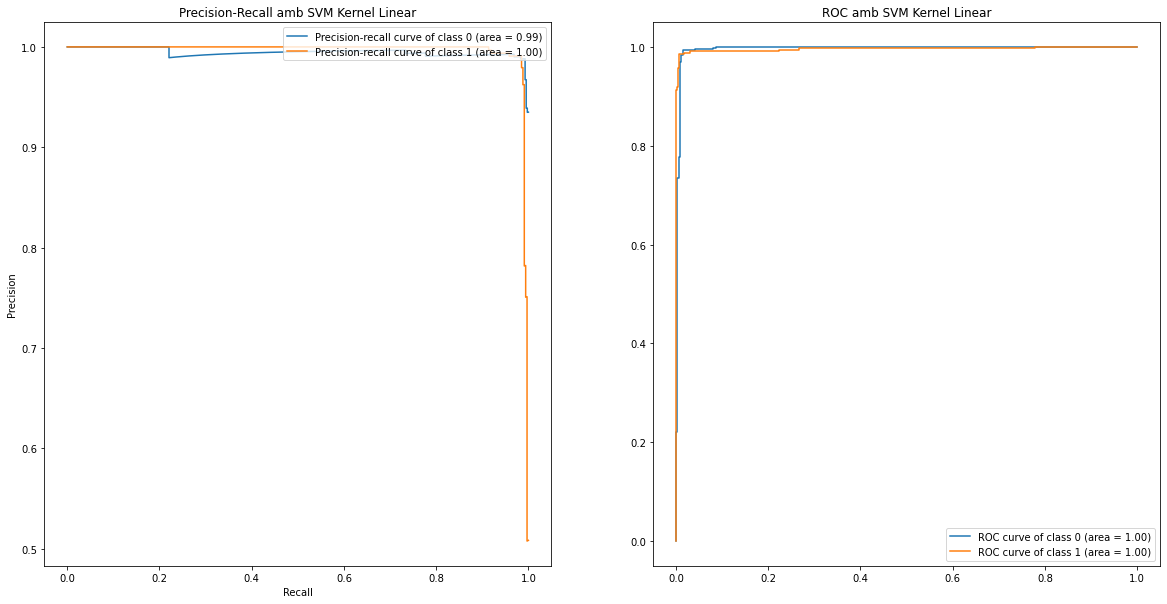

In [325]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb SVM Kernel Linear', y_v=y_test)
ROC(probs, ax[1], 'ROC amb SVM Kernel Linear', y_v=y_test)

#### LINEARSVC

In [326]:
#LINEARSVC
C = [x for x in np.linspace(start = 0.001, stop = 10, num = 1000)]

penalty = ['l1','l2']

loss = ['hinge', 'squared_hinge']

dual = [True, False]

max_iter = [int(x) for x in np.linspace(start = 1000, stop = 100000, num=1000)]


svclinear = {'C': C,
          'penalty':penalty,
          'loss':loss,
          'dual':dual,
          'max_iter':max_iter
              }

In [327]:
svm_svclinear = svm.LinearSVC(random_state=123)
svcl_random = RandomizedSearchCV(estimator = svm_svclinear, param_distributions = svclinear, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
svcl_random.fit(X_train, y_train)
end = time.time()
svm_timehyper.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.2s finished


In [368]:
svcl_random.best_params_

{'penalty': 'l2',
 'max_iter': 54711,
 'loss': 'hinge',
 'dual': True,
 'C': 4.865378378378379}

In [359]:
base_model = svm.LinearSVC(random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9853917662682603

In [360]:
best_random = svcl_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_hyper.append(random_accuracy)
random_accuracy

0.9880478087649402

In [361]:
improve_svm.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.27%.


In [364]:
print("                           LINEAR SVC                    ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                           LINEAR SVC                    
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9880478087649402 | 0.9821428571428571 | 0.9865470852017937 |
+--------------------+--------------------+--------------------+


#### SVM KERNEL RBF

In [332]:
#RBF
C = [x for x in np.linspace(start = 0.001, stop = 10, num = 1000)]

gamma = ['scale','auto']


rbf = {'C': C,
          'gamma':gamma
              }

In [333]:
svm_rbf = svm.SVC(kernel='rbf',random_state=123, probability=True)
rbf_random = RandomizedSearchCV(estimator = svm_rbf, param_distributions = rbf, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
rbf_random.fit(X_train, y_train)
end = time.time()
svm_timehyper.append(end-start)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   13.4s finished


In [369]:
rbf_random.best_params_

{'gamma': 'scale', 'C': 9.08918018018018}

In [334]:
base_model = svm.SVC(kernel='rbf',random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9893758300132802

In [335]:
best_random = rbf_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_hyper.append(random_accuracy)
random_accuracy

0.9907038512616202

In [336]:
improve_svm.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.13%.


In [337]:
print("                         SVM KERNEL RBF                    ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                         SVM KERNEL RBF                    
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9907038512616202 | 0.9880952380952381 | 0.9895678092399405 |
+--------------------+--------------------+--------------------+


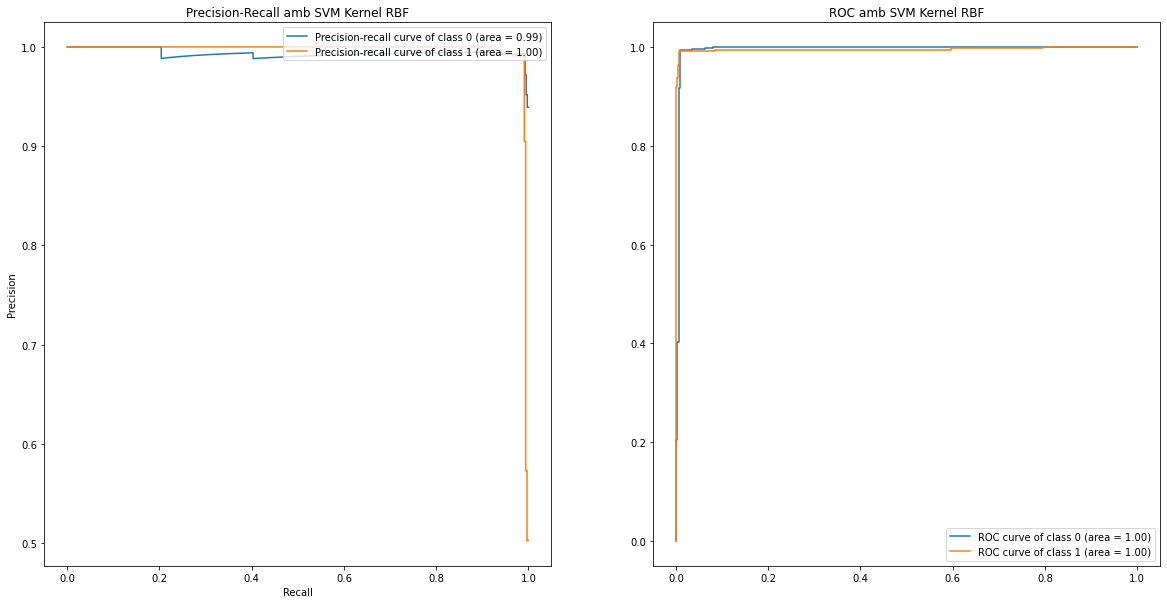

In [338]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb SVM Kernel RBF', y_v=y_test)
ROC(probs, ax[1], 'ROC amb SVM Kernel RBF', y_v=y_test)

#### SVM KERNEL POLYNOMIAL

In [339]:
#POLYNOMIAL
C = [x for x in np.linspace(start = 0.001, stop = 10, num = 1000)]

gamma = ['scale','auto']

degree = [3,4,5,6,7,8]

coef0 = [x for x in np.linspace(start= 0.0,stop= 1,num=100)]




poly = {'C': C,
          'gamma':gamma,
       'degree':degree,
       'coef0':coef0
              }

In [340]:
svm_poly = svm.SVC(kernel='poly',random_state=123, probability=True)
poly_random = RandomizedSearchCV(estimator = svm_poly, param_distributions = poly, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
poly_random.fit(X_train, y_train)
end = time.time()
svm_timehyper.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 29.8min finished


In [370]:
poly_random.best_params_

{'gamma': 'scale',
 'degree': 4,
 'coef0': 0.23232323232323235,
 'C': 0.3913513513513514}

In [341]:
base_model = svm.SVC(kernel='poly',random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.9893758300132802

In [342]:
best_random = poly_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_hyper.append(random_accuracy)
random_accuracy

0.9893758300132802

In [343]:
improve_svm.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 0.00%.


In [344]:
print("                      SVM KERNEL POLYNOMIAL                    ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                      SVM KERNEL POLYNOMIAL                    
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9893758300132802 | 0.9851190476190477 | 0.9880597014925373 |
+--------------------+--------------------+--------------------+


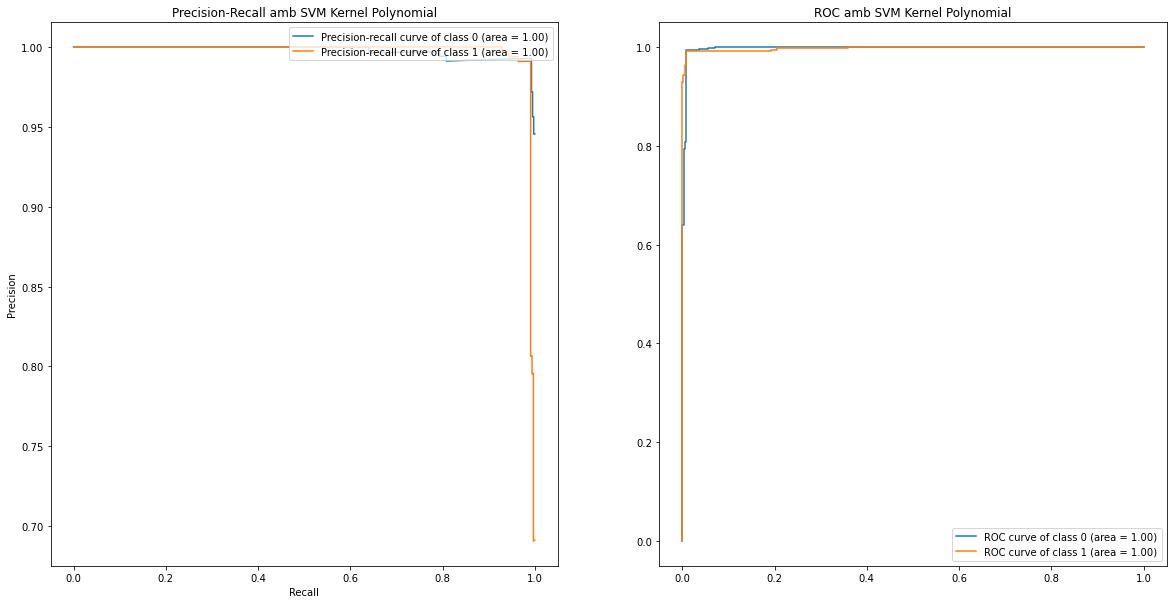

In [345]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb SVM Kernel Polynomial', y_v=y_test)
ROC(probs, ax[1], 'ROC amb SVM Kernel Polynomial', y_v=y_test)

#### SVM KERNEL SIGMOID

In [346]:
#SIGMOID
C = [x for x in np.linspace(start = 0.001, stop = 10, num = 1000)]

gamma = ['scale','auto']

coef0 = [x for x in np.linspace(start= 0.0,stop= 1,num=100)]




sigmoid = {'C': C,
        'gamma':gamma,
       'coef0':coef0
              }

In [347]:
svm_sig = svm.SVC(kernel='sigmoid',random_state=123, probability=True)
sig_random = RandomizedSearchCV(estimator = svm_sig, param_distributions = sigmoid, n_iter = 100, cv = 5, verbose=2, random_state=123, n_jobs = -1)
# Fit the random search model
start = time.time()
sig_random.fit(X_train, y_train)
end =  time.time()
svm_timehyper.append(end-start)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


In [371]:
sig_random.best_params_

{'gamma': 'auto', 'coef0': 0.4040404040404041, 'C': 9.329396396396396}

In [356]:
base_model = svm.SVC(kernel='sigmoid',random_state=123)
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

base_accuracy = metrics.accuracy_score(y_test, y_pred)
base_accuracy

0.2204515272244356

In [357]:
best_random = sig_random.best_estimator_
y_pred=best_random.predict(X_test)
best_random.score(X_test,y_test)


random_accuracy = metrics.accuracy_score(y_test, y_pred)
svm_hyper.append(random_accuracy)
random_accuracy

0.9880478087649402

In [358]:
improve_svm.append((100*(random_accuracy - base_accuracy) / base_accuracy))
print('Millora un {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Millora un 348.19%.


In [351]:
print("                       SVM KERNEL SIGMOID                    ")
ptbl = PrettyTable()
ptbl.field_names = ["Accuracy", "Recall", "F1Score"]
ptbl.add_row([accuracy_score(y_test,best_random.predict(X_test)),
          recall_score(y_test, best_random.predict(X_test)), f1_score(y_test, best_random.predict(X_test))])
print(ptbl)

                       SVM KERNEL SIGMOID                    
+--------------------+--------------------+--------------------+
|      Accuracy      |       Recall       |      F1Score       |
+--------------------+--------------------+--------------------+
| 0.9880478087649402 | 0.9821428571428571 | 0.9865470852017937 |
+--------------------+--------------------+--------------------+


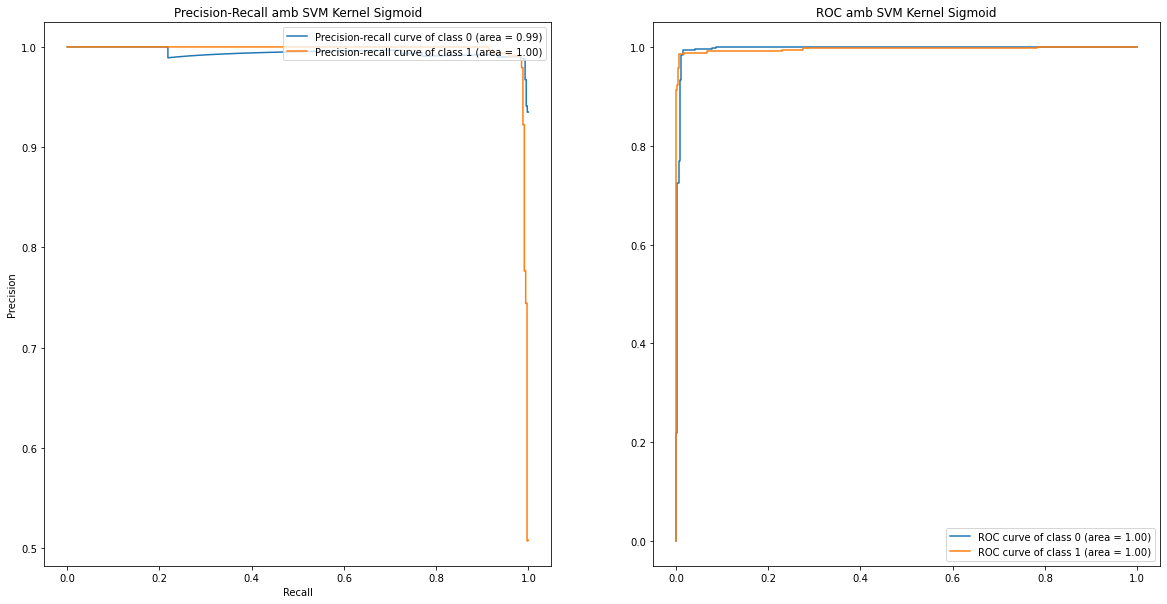

In [352]:
n_classes = 2

probs = best_random.predict_proba(X_test)

fig, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()

plot_precision_recall(probs, ax[0], 'Precision-Recall amb SVM Kernel Sigmoid', y_v=y_test)
ROC(probs, ax[1], 'ROC amb SVM Kernel Sigmoid', y_v=y_test)

In [407]:
svm_tblCompare = PrettyTable()
svm_tblCompare.field_names = ['Model', 'Accuracy w/o HT', 'Accuracy w/ HT', 'Time w/o HT(s)','Time spent on HT (s)','Improve']
idx = 0
for m in svm_kernels: 
    svm_tblCompare.add_row([m, svm_nohyper[idx], svm_hyper[idx], svm_time_nohyper[idx],svm_timehyper[idx],improve_svm[idx]])
    idx+=1
print(svm_tblCompare)

+-------------+---------------------+--------------------+----------------------+----------------------+---------------------+
|    Model    |   Accuracy w/o HT   |   Accuracy w/ HT   |    Time w/o HT(s)    | Time spent on HT (s) |       Improve       |
+-------------+---------------------+--------------------+----------------------+----------------------+---------------------+
|    Linear   |  0.9727484214024593 | 0.9893758300132802 | 0.03191637992858887  |  13.47374415397644   | 0.13440860215053752 |
|  SVC Linear |  0.9717514124293786 | 0.9880478087649402 | 0.006978273391723633 |  3.306173801422119   |  0.269541778975741  |
|     RBF     |  0.9744101030242606 | 0.9907038512616202 | 0.03988242149353027  |  13.599499940872192  | 0.13422818791946298 |
| Polyniomial |  0.9777334662678631 | 0.9893758300132802 | 0.032918453216552734 |  1785.540244102478   |         0.0         |
|   Sigmoid   | 0.21468926553672316 | 0.9880478087649402 |  0.4429788589477539  |  78.58683037757874   |  348.1

In [410]:
tuned_kernels = [sl_random.best_estimator_, svcl_random.best_estimator_, rbf_random.best_estimator_, 
          poly_random.best_estimator_, sig_random.best_estimator_]
svm_train_tbl = PrettyTable()
svm_train_tbl.field_names = ['Model', 'Accuracy w/o HT', 'Accuracy w/ HT', 'Time w/o HT(s)', 'Time w/ HT (s)']
idx = 0
for m in tuned_kernels: 
    start = time.time()
    m.fit(X_train, y_train)
    end = time.time()
    svm_train_tbl.add_row([svm_kernels[idx], svm_nohyper[idx], svm_hyper[idx], svm_time_nohyper[idx],end-start])
    idx+=1
print(svm_train_tbl)

+-------------+---------------------+--------------------+----------------------+-----------------------+
|    Model    |   Accuracy w/o HT   |   Accuracy w/ HT   |    Time w/o HT(s)    |     Time w/ HT (s)    |
+-------------+---------------------+--------------------+----------------------+-----------------------+
|    Linear   |  0.9727484214024593 | 0.9893758300132802 | 0.03191637992858887  |  0.05585074424743652  |
|  SVC Linear |  0.9717514124293786 | 0.9880478087649402 | 0.006978273391723633 | 0.0059850215911865234 |
|     RBF     |  0.9744101030242606 | 0.9907038512616202 | 0.03988242149353027  |  0.11401939392089844  |
| Polyniomial |  0.9777334662678631 | 0.9893758300132802 | 0.032918453216552734 |   0.1414327621459961  |
|   Sigmoid   | 0.21468926553672316 | 0.9880478087649402 |  0.4429788589477539  |  0.09423971176147461  |
+-------------+---------------------+--------------------+----------------------+-----------------------+


In [354]:
models = [sl_random.best_estimator_, svcl_random.best_estimator_, rbf_random.best_estimator_, poly_random.best_estimator_, sig_random.best_estimator_]
false_negative = []
for m in models:
    pred = m.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    false_negative.append(fn)

print(f"El SVM més bo és el {svm_kernels[false_negative.index(min(false_negative))]} amb {min(false_negative)} falsos negatius")

El SVM més bo és el RBF amb 4 falsos negatius


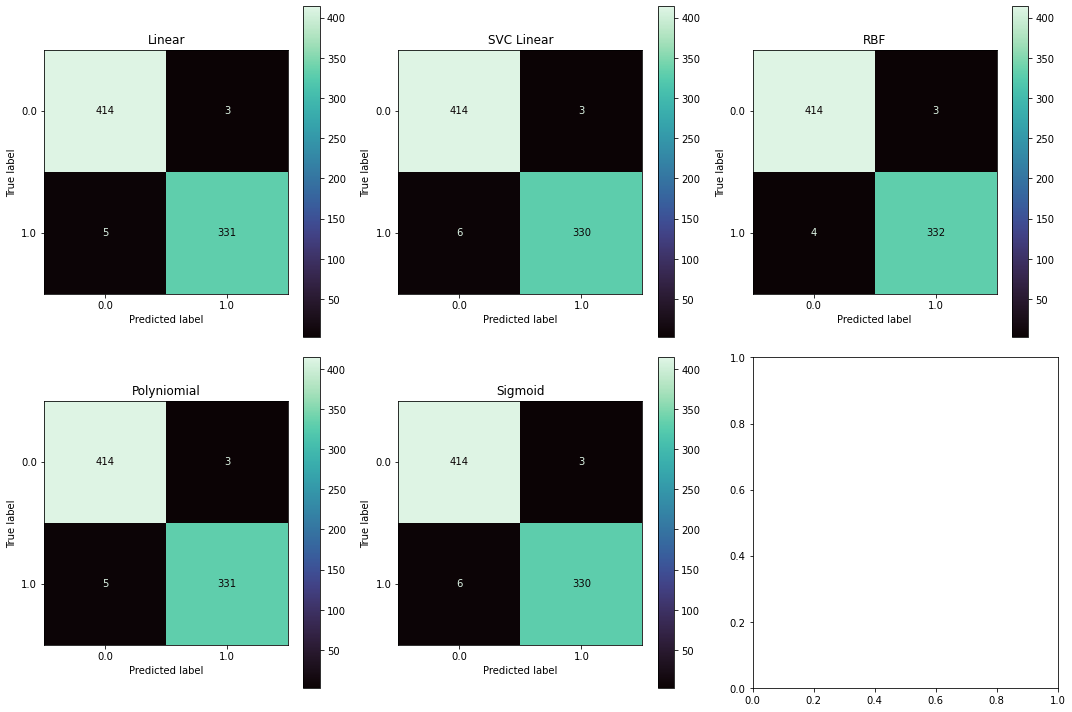

In [355]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
idx=0
for cls, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='mako',
                         )
    ax.title.set_text(svm_kernels[idx])
    idx+=1

plt.tight_layout()  
plt.show()

### 9. Results

After having realized many studies and having seen the confusion matrices, we can say that most of the models work pretty similarly and there is no big difference beetween ones or others. However, to be consistent with our hypothesis we will keep the model that classifies the false negatives better, so that means that it has less false negative cases. In our case it is the Random Forest, even though it is not the only model that gives you 4 false negatives, it has the best classification between them.

We can also visualize the Precision-Recall and the ROC curve that shows the performance of our models. These curves are really close to 1 or even 1, which means that they are classifying well. 

### 10. Analyzing through images

After analyzing numbers, we will go through analyzing images which might be more interesting. In order to do it, we will be using some pretrained models from pytorch.

To do it we will have to have the data structured the following way:

![alt text](directory.png)

That way we allow our model to train properly and then make its predictions.

In [118]:
from torchvision import models
actual_dir = os.getcwd() 
folder_name="Brain Tumor"
data_dir = os.path.join(actual_dir, folder_name)

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset (0 and 1)
num_classes = 2

# Batch size for training (randomly images from our data we are picking in each iteration to train our model)
batch_size = 32

# Number of epochs to train for 
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

We define the function to train our model and calculate loss and accuracy scores for each phase (*train* and *validation*) and we keep those values to plot the graphics in the future.

In [119]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc = []
    loss_hist = []
    train_loss= []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                loss_hist.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss, train_acc, val_acc_history, loss_hist

In [120]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Depending on our model we will initialize one or another pretrained model, in our case we are using *squeezenet*

In [122]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    #this model requires scipy installed
    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

We define transforms to our data

In [123]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [124]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

#as we are not finetuning we will only update those parameters that we just initialized
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


We train our model and keep the values for each epoch

In [125]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, train_loss, train_acc, hist, loss = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/49
----------
train Loss: 0.5335 Acc: 0.7296
val Loss: 0.4951 Acc: 0.7620

Epoch 1/49
----------
train Loss: 0.4178 Acc: 0.8163
val Loss: 0.3937 Acc: 0.8391

Epoch 2/49
----------
train Loss: 0.3891 Acc: 0.8249
val Loss: 0.3683 Acc: 0.8511

Epoch 3/49
----------
train Loss: 0.3818 Acc: 0.8226
val Loss: 0.3968 Acc: 0.8271

Epoch 4/49
----------
train Loss: 0.3704 Acc: 0.8359
val Loss: 0.3785 Acc: 0.8404

Epoch 5/49
----------
train Loss: 0.3592 Acc: 0.8468
val Loss: 0.3435 Acc: 0.8511

Epoch 6/49
----------
train Loss: 0.3284 Acc: 0.8598
val Loss: 0.3026 Acc: 0.8910

Epoch 7/49
----------
train Loss: 0.3364 Acc: 0.8595
val Loss: 0.3264 Acc: 0.8777

Epoch 8/49
----------
train Loss: 0.3366 Acc: 0.8561
val Loss: 0.3153 Acc: 0.8803

Epoch 9/49
----------
train Loss: 0.3466 Acc: 0.8505
val Loss: 0.3572 Acc: 0.8471

Epoch 10/49
----------
train Loss: 0.3257 Acc: 0.8595
val Loss: 0.3023 Acc: 0.8949

Epoch 11/49
----------
train Loss: 0.3385 Acc: 0.8508
val Loss: 0.3307 Acc: 0.8790

Ep

### 11. Results

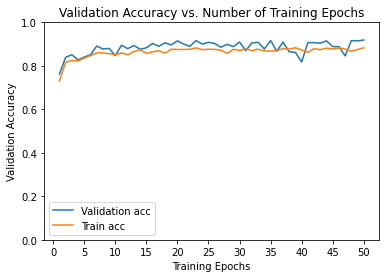

In [126]:
#We compare the accuracy between train and validation phase for all epochs
ohist = []
train_hist = [x for x in train_acc]

ohist = [h.cpu().numpy() for h in hist]
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Validation acc")
plt.plot(range(1,num_epochs+1),train_hist,label="Train acc")
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5))
plt.legend()
plt.show()

We can see that accuracy goes up by the time we increase epochs. It seems the accuracy is stable near 0.91, so we might say that our model can make some great predictions.

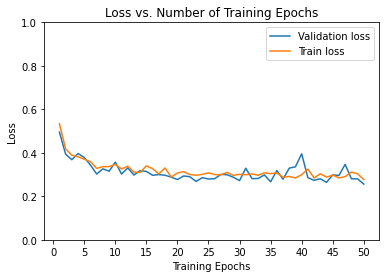

In [127]:
#we plot the loss of our model comparing between validation and train phases
losshist = []
train_loss = [x for x in train_loss]
losshist =[h for h in loss]
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),losshist,label="Validation loss")
plt.plot(range(1,num_epochs+1),train_loss,label="Train loss")
plt.ylim((0,1.))
plt.xticks(np.arange(0, num_epochs+1, 5.0))
plt.legend()
plt.show()

We can see how loss is in a down trend which is a good signal and indicates us that our model might be making good predictions.
If we look carefully near epoch 40 we can see that there is a peak and we could treat that as an exception because it is not the usual trend.

Now we can observe some classifications of our model and see how does our model work.

In [128]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5])
    std = np.array([0.5,0.5,0.5])
    inp = std * inp + mean
    axis.imshow(inp)

In [129]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    use_gpu = torch.cuda.is_available()
    for i, (inputs, labels) in enumerate(dataloders['val']):
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

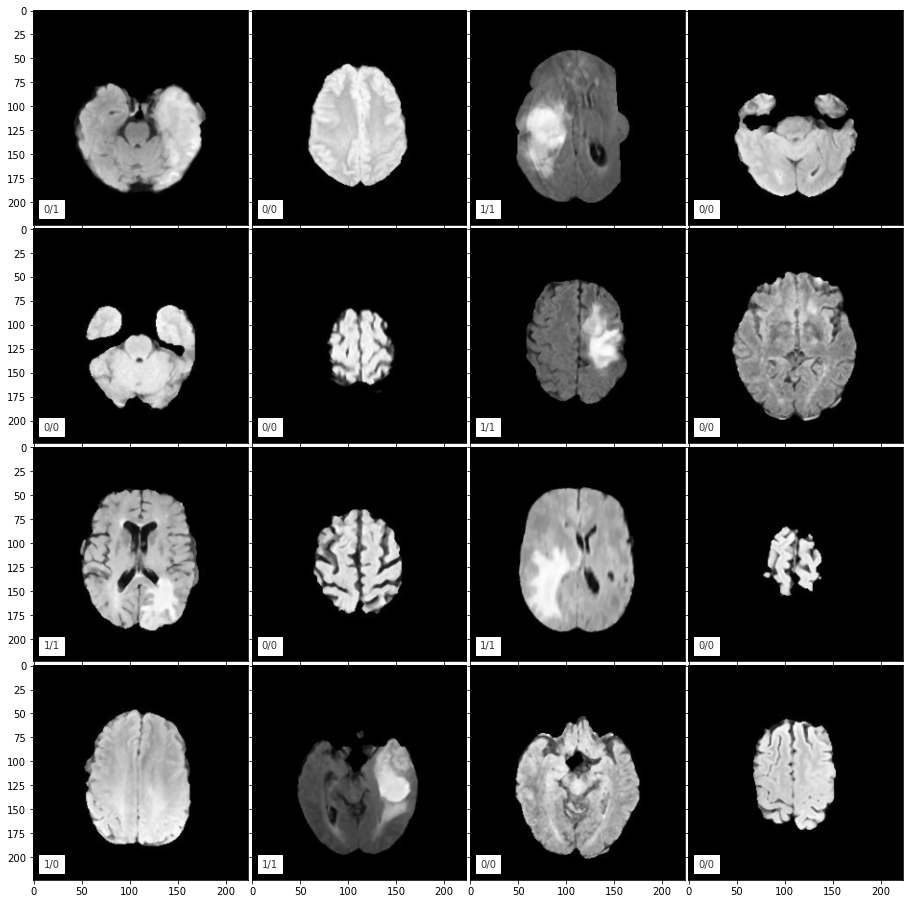

In [130]:
visualize_model(dataloaders_dict, model_ft)

After watching those images we can see that our model is predicting quite well, however, there are some mistakes in some images and we might think that it is because the image is not in the best quality possible or is not really clear and that is also difficult for the human eye to diganose if there is a tumor or not.

### 12. Conclusions
After obtaining all the results and watching the graphics we can say a few things about our problem:  

- Sklearn models are slightly better than SVM models
- Non applying hyperparameters to our models gives us good accuracies, so that would mean that our data is highly correlated in order to make good predictions. And knowing that tuning the hyperparameters is not something quick  we could say that with the base models is enough. However, as we are experiencing some improvements and the predictions are better, we should keep the latest model possible.
- A good amount of columns is irrelevant. We are only using those attributes that are highly correlated and show a better distribution to diagnose if there is a tumor or not.
- Looking at the predictions of our images we could say that those images that are pretty clear are easy classified, however, the ones that are not that clear are a bit more complicated. In order to improve that, it might be interesting to crop the image to get the brain as big as possible and apply a better filter for the transformations.

If you want to watch more there are some interesting kernels on Kaggle repository:
- [Image Kernel](https://www.kaggle.com/angieashraf/89-brain-tumor-detection-using-dl)
- [Predicting through numbers](https://www.kaggle.com/albertozorzetto/98-brain-tumor-classification)


### 13. Annex

We are going to save our session and some models.

In [414]:
dill.dump_session('brain_tumor_session.db')

In [412]:
transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ])

In [413]:
joblib.dump(model_ft, 'squeezenet.pkl') # Guardem el model per les imatges
joblib.dump(sig_random, 'sigmoid.pkl') # Guardem el kernel sigmoid
joblib.dump(poly_random, 'polynomical.pkl') # Guardem el kernel polynomial
joblib.dump(rbf_random, 'rbf.pkl') # Guardem el kernel rbf
joblib.dump(svcl_random, 'svcl.pkl') # Guardem el LinearSVC
joblib.dump(sl_random, 'sl.pkl') # Guardem el kernel linear
joblib.dump(mlp_random, 'mlp.pkl') # Guardem el MLP
joblib.dump(xb_random, 'xb.pkl') # Guardem el XGBoost
joblib.dump(ada_random, 'ada.pkl') # Guardem l'AdaBoost
joblib.dump(rf_random, 'rf.pkl') # Guardem el RandomForest
joblib.dump(dt_random, 'dt.pkl') # Guardem el Decision Tree
joblib.dump(lr_random, 'lr.pkl') # Guuardem el Logistic
joblib.dump(dataset,'dataset.pkl') #guardem el nostre dataset ja netejat
joblib.dump(dataset.axes[1][variablesIndex],'atributes.pkl') #guardem la llista d'atributs que considerem importants
joblib.dump(transform,'image_transform.pkl') #Guardem com transformem lles imatges

with open("normalize.pkl","wb") as f:
    dill.dump(normalize_df,f)#guardem la funcio per normalitzar el DataFrame
with open("load_data.pkl","wb") as f:
    dill.dump(load_dataset,f)     #guardem la funció per carregar nous datasets
print("Tots els models s'han guardat")


Tots els models s'han guardat
